## Data Analysis and Preprocess

In [ ]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en_core_web_sm
# Just a bunch of libraries that I've used in the notebook
import psycopg2 as pg
from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import statistics
import math
import re
import nltk

import string
import spacy
from spacy.lang.en import English

import matplotlib.pyplot as plt
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-11-04 14:46:07.027373: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Read the dataset 

In [ ]:
# Mounting Google Drive
from google.colab import drive  # to mount Google Drive to Colab notebook
drive.mount('/content/drive') 
path='./drive/My Drive/Colab Notebooks/'



Mounted at /content/drive


In [ ]:
df = pd.read_csv(path+'Children-Books(new).csv')
df.head()

,Title,Author,Moral,Content
0,Meera and Ameera,Nimmy Chacko,Friendship,Meera and I are a team. She’s my most favourit...
1,Every Minute Counts,Shabnam Minwalla,Friendship,Adil is always late to school.\nHis class teac...
2,Mali's Friend,Rujeko Moyo,Friendship,Mali enjoys playing by himself.\nHe likes to b...
3,My Best Friend – short story with imagination,Anupa,Friendship,I have a friend. She lives in my house.\n\nWhe...
4,Same-Same or Different? Being friends despite ...,Roopa Pai,Friendship,Mamma put Sparrow’s lunchbox into her schoolba...


In [ ]:
df.describe()

,Title,Author,Moral,Content
count,127,16,127,127
unique,117,15,5,77
top,LOVE DROPS,T. Albert,Friendship,"respect, look after, respectful, considerate, ..."
freq,3,2,28,11


# **Overview of dataset**

As you can see in the following plot, the samples are balanced. 


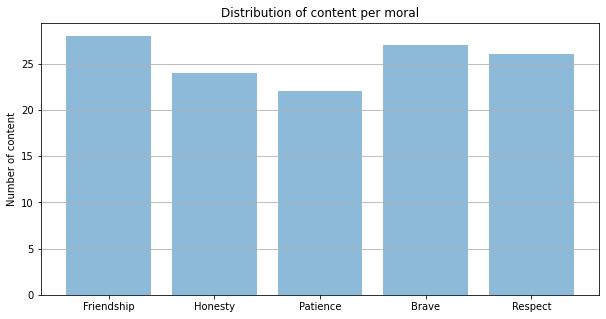

Counter({'Friendship': 28, 'Brave': 27, 'Respect': 26, 'Honesty': 24, 'Patience': 22})


In [ ]:
Morals = df[['Moral']].values.reshape(-1)

counter_Morals = Counter(Morals)
Moral_names = counter_Morals.keys()
Moral_values = counter_Morals.values()

y_pos = np.arange(len(Moral_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, Moral_values, align='center', alpha=0.5)
plt.xticks(y_pos, Moral_names)
plt.ylabel('Number of content')
plt.title('Distribution of content per moral')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_Morals)

In [ ]:
def calculate_stats(df, split_char=' '):
    Morals = df['Moral'].unique()
    
    all_lengths = []
    per_Moral = {
        'lengths': {c:[] for c in Morals},
        'mean': {c:0 for c in Morals},
        'stdev': {c:0 for c in Morals}
    }

    for index, row in df.iterrows():
        Content = row['Content']
        Content = re.sub(r"\s+", ' ', Content) # Normalize
        Content = Content.split(split_char)
        l = len(Content)
        
        Moral = row['Moral']
        
        all_lengths.append(l)
        per_Moral['lengths'][Moral].append(l)
    
    for c in Morals:
        per_Moral['mean'][c] = statistics.mean(per_Moral['lengths'][c])
        per_Moral['stdev'][c] = statistics.stdev(per_Moral['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_Moral': pd.DataFrame(per_Moral)
    }

In [ ]:
def display_lengths_histograms(df_stats, n_cols=3):
    Morals = df['Moral'].unique()
    n_rows = math.ceil(len(Morals) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All Morals')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each Moral
    index_subplot = 2
    for c in Morals:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Moral: %s' % c)
        
        lengths = df_stats['per_Moral']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = {} # Here we will store the statistics after each preprocess

df_stats['initial'] = calculate_stats(df)
df_stats['initial']['per_Moral']

,lengths,mean,stdev
Friendship,"[186, 324, 211, 119, 559, 223, 364, 476, 569, ...",284.964286,363.496343
Honesty,"[172, 240, 330, 494, 436, 804, 192, 591, 370, ...",273.500000,227.751772
Patience,"[407, 534, 262, 595, 261, 220, 144, 365, 764, ...",272.272727,346.179582
Brave,"[1165, 801, 205, 511, 500, 498, 776, 319, 631,...",319.518519,329.181546
Respect,"[231, 364, 445, 609, 227, 480, 222, 417, 392, ...",185.461538,183.138031


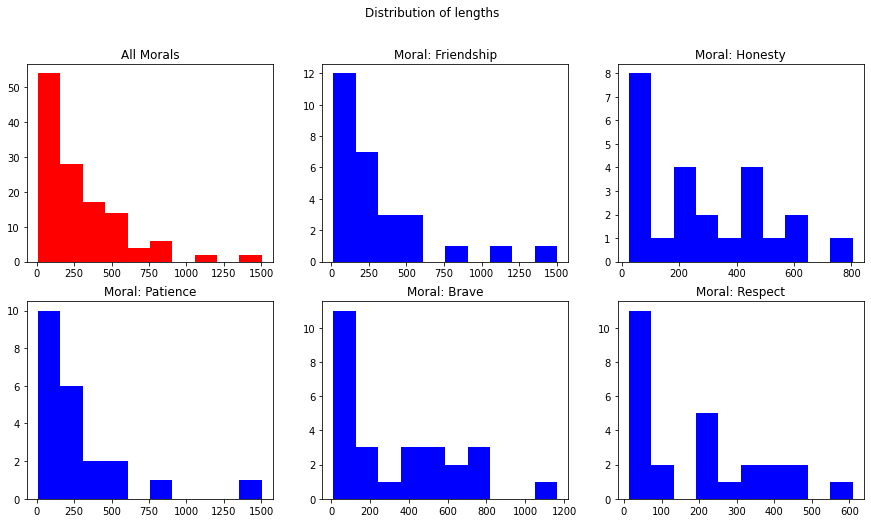

In [ ]:
display_lengths_histograms(df_stats['initial'])

# **Preprocess: clean characters**

Before we start to apply other techniques to clean the texts, we have removed every character which cannot be used to write words in English (this set of characters is different in other languages). Using the following function, I have removed all puntuation symbols from all texts as well as I have normalized the white spaces.

In [ ]:
def apply_char_cleaner(df):
    for index, row in df.iterrows():
        Content = row['Content']
        
        for symbol in list(string.punctuation) :
            # Replace the string
            Content = Content.replace(symbol, ' ')

        # Normalize white spaces
        Content = re.sub(r"\s+", ' ', Content)
        
        row['Content'] = Content
    
    return df

In [ ]:
df = apply_char_cleaner(df)
df.head() # Sample

,Title,Author,Moral,Content
0,Meera and Ameera,Nimmy Chacko,Friendship,Meera and I are a team She’s my most favourite...
1,Every Minute Counts,Shabnam Minwalla,Friendship,Adil is always late to school His class teache...
2,Mali's Friend,Rujeko Moyo,Friendship,Mali enjoys playing by himself He likes to be ...
3,My Best Friend – short story with imagination,Anupa,Friendship,I have a friend She lives in my house When I a...
4,Same-Same or Different? Being friends despite ...,Roopa Pai,Friendship,Mamma put Sparrow’s lunchbox into her schoolba...


In [ ]:
df_stats['char_cleaner'] = calculate_stats(df)
df_stats['char_cleaner']['per_Moral']

,lengths,mean,stdev
Friendship,"[190, 341, 217, 122, 623, 232, 366, 489, 610, ...",295.607143,378.505378
Honesty,"[173, 246, 331, 512, 439, 808, 195, 593, 375, ...",273.875000,234.025698
Patience,"[413, 544, 271, 603, 265, 223, 146, 367, 770, ...",276.954545,355.803380
Brave,"[1208, 810, 223, 513, 511, 507, 810, 332, 656,...",329.851852,335.261976
Respect,"[233, 367, 455, 624, 228, 479, 224, 418, 394, ...",187.961538,184.666506


# **Preprocess: Stop words**

Stop words are a set of commonly used words in any language. For example, in English, "the", "is" and "or" using spacy library, would easily qualify as stop words. These words are not semantically useful in the sentences, thus it is a good idea to remove them and focus on important words instead.

In [ ]:
def apply_stop_words(df, join_char=' ', split_char=' '):
    #new_stopwords=['lunchbox ','King','Princess','lived','live','like','young','not','Not','schoolbag','Everything','Animal','animal','Animals','animals','dragon','Dragon','baby','great','house','home','day','making','beautiful','grandma','down','morning','breakfast','nobody','Come','here','afternoon','All','about','into','talk','parents','king','queen','anything','flowers','few','little','children','woman','everyday','really','pencil','daughter','fly','born','back','nothing','night','things','favourite','know','normal','inside','yesterday','phone','number','man','stop','people','weekend','rain','days','bear','dark','never','next','kid','Dear','moment','down','because','something','one','see','few','days','very','time','upon','Once','Before','However','boy','Boy','Girl','girl','Everybody','from','told','Since','until','Until','but','But','Yes','yes','no','said','No','who','world',"didn’t",'want','Mother','mother','grandmother','Where','Daddy','Mummy','Grandmother','teacher','school','person','Brother','Sister','Grandma','Do','When', 'me','She',"She’s",'His','He',"He's",'Her', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours','And', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation) + #list(new_stopwords)
    
    nlp = English()
    # stemming: return the word to it root
    #df = stemming(df)
    for index, row in df.iterrows():
        tokens = row['Content'].split(split_char)
        Content = [w for w in tokens if w not in stop_words]
        row['Content'] = join_char.join(Content)
    
    
    return df

In [ ]:
df = apply_stop_words(df)
df.head() # Sample

,Title,Author,Moral,Content
0,Meera and Ameera,Nimmy Chacko,Friendship,Meera I team Meera makes problems I away takes...
1,Every Minute Counts,Shabnam Minwalla,Friendship,Adil late class Miss Rupal angry “You missed 1...
2,Mali's Friend,Rujeko Moyo,Friendship,Mali enjoys playing likes pilot swooshing pape...
3,My Best Friend – short story with imagination,Anupa,Friendship,I friend lives I happy I cry cries care I hear...
4,Same-Same or Different? Being friends despite ...,Roopa Pai,Friendship,Mamma Sparrow’s lunchbox folded wings “And rem...


In [ ]:
df_stats['stop_words'] = calculate_stats(df)
df_stats['stop_words']['per_Moral']

,lengths,mean,stdev
Friendship,"[73, 201, 105, 49, 369, 120, 157, 211, 351, 16...",143.607143,177.455125
Honesty,"[82, 121, 136, 243, 185, 320, 73, 249, 140, 93...",118.875000,95.182348
Patience,"[145, 236, 140, 258, 97, 88, 54, 162, 334, 711...",117.636364,160.643215
Brave,"[528, 361, 137, 222, 223, 213, 405, 163, 326, ...",148.444444,144.219740
Respect,"[96, 141, 199, 235, 89, 175, 88, 178, 149, 77,...",77.076923,70.038231


# **Summary of parsed dataset**

<Figure size 1080x576 with 0 Axes>

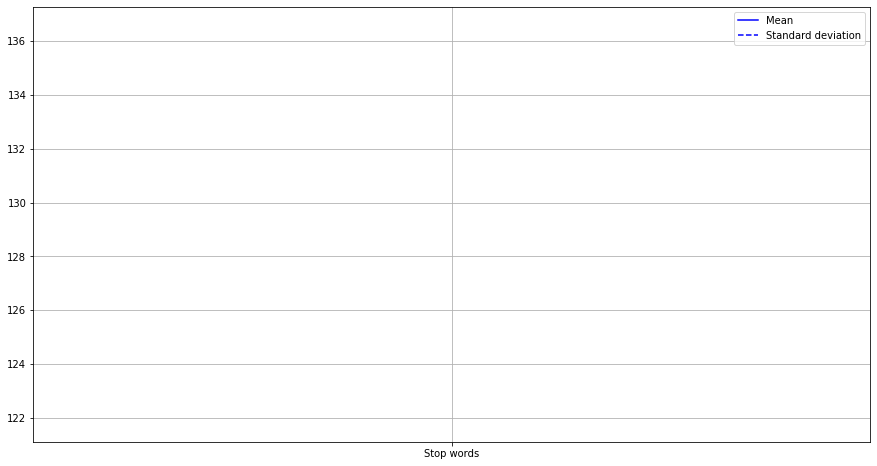

In [ ]:
plt.figure(figsize=(15, 8))

# Subplot of all lengths
names = ['stop_words']
mean = []
stdev = []

for name, ds in df_stats.items():
    if name not in names:
        continue
    
    mean.append(ds['global']['mean'])
    stdev.append(ds['global']['stdev'])

x = ['Stop words']

plt.figure(figsize=(15, 8))
plt.plot(x, mean, color='b', label='Mean', linestyle='-')
plt.plot(x, stdev, color='b', label='Standard deviation', linestyle='--')
plt.grid()
plt.legend()
plt.show()

## **Store parsed dataset**

Finally, I have stored the dataset as a CSV file, so I could use it in the  models 

In [ ]:
df.to_csv(path+'parsed-79.csv')